# Fall 2020: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 1: Bag-of-Words based Natural Language Inference (30 pts)

In this assignment, you will train a Bag-of-Words encoder to tackle the Stanford Natural Language Inference (SNLI) task.

We have 5 coding questions and 3 written questions. Some coding functions are provided for your reference, but you are welcome to change and write your own functions. You should deliver your training and validation results in written questions.

In [1]:
# Import required packages
import os 
import numpy as np
import pickle as pkl
from tqdm import tqdm
from collections import Counter
from collections import defaultdict

import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
import itertools

In [101]:
# from google.colab import drive
# drive.mount('/content/drive')
path = os.getcwd() + "/data_after_process"
os.chdir(path)


In [3]:
# save index 0 for unk and 1 for pad
global PAD_IDX, UNK_IDX
UNK_IDX = 0
PAD_IDX = 1

In [97]:
#save training progress 
def get_full_filepath(path, enc_type):
    filename = enc_type+'_dec_bow.pth'
    return os.path.join(path, filename)
def save_models(nmt_model, path, enc_type):
    if not os.path.exists(path):
            os.makedirs(path)
    filename = str(enc_type)+'_dec_bow.pth'
    torch.save(nmt_model, os.path.join(path, filename))

---
### 1 Dataset (6 pts)
#### Data Processing

In [6]:
# Read data
# tokenized data provided or you can tokenize data by your self
folder = os.getcwd() + '/data_after_process/'

hypo_data_tokens_train = pkl.load(open(folder+"hypo_data_tokens_train.p", "rb"))
prem_data_tokens_train = pkl.load(open(folder+"prem_data_tokens_train.p", "rb"))

hypo_data_tokens_val = pkl.load(open(folder+"hypo_data_tokens_val.p", "rb"))
prem_data_tokens_val = pkl.load(open(folder+"prem_data_tokens_val.p", "rb"))

label_index_train = pkl.load(open(folder+"label_index_train.p", "rb"))
label_index_val = pkl.load(open(folder+"label_index_val.p", "rb"))



**Coding 1: finish `build_vocab` function** (2 pts)


In [7]:
def build_vocab(hypo_tokens, prem_tokens, max_vocab_size=10000):
    # TODO:
    # build vocab
    # returns: 
    # - id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # - token2id: dictionary where keys represent tokens and corresponding values represent indices
    PAD_IDX = 0
    UNK_IDX = 1

    all_tokens_hypo = [token for tokens in hypo_tokens for token in tokens]
    all_tokens_prem = [token for tokens in prem_tokens for token in tokens]
    all_tokens = all_tokens_hypo + all_tokens_prem
    

    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    token2id = dict(zip(vocab, range(2, 2 + len(vocab))))
    token2id["<PAD>"] = PAD_IDX
    token2id["<UNK>"] = UNK_IDX
    id2token = ["<PAD>", "<UNK>"] + list(vocab)

    return  token2id, id2token


In [8]:
print(hypo_data_tokens_train[:5])

[['a', 'young', 'girl', 'in', 'a', 'pink', 'shirt', 'sitting', 'on', 'a', 'dock', 'viewing', 'a', 'body', 'of', 'water'], ['a', 'woman', 'is', 'smiling', 'while', 'the', 'man', 'next', 'to', 'her', 'is', 'focused', 'on', 'a', 'blue', 'object', 'with', 'a', 'pattern', 'on', 'it'], ['across', 'the', 'river', 'you', 'can', 'see', 'a', 'large', 'building'], ['a', 'man', 'in', 'white', 'shorts', 'and', 'a', 'black', 'shirt', 'is', 'paragliding', 'on', 'the', 'ocean'], ['four', 'black', 'dogs', 'run', 'together', 'on', 'bright', 'green', 'grass']]


**Coding 2: finish `token2index` function** (2 pts)

In [9]:
def token2index(tokens_data):
    # TODO:
    # convert token to id in the dataset
    # returns:
    # - indices_data: return list of index_list (index list for each sentence)
    #indices_data = [[token2id.get(ele) for ele in item] for item in tokens_data]
    indices_data = []
    for tokens in tqdm(tokens_data):
        indices = [token2id.get(token, 1) for token in tokens]
        indices_data.append(indices)
    
    return indices_data

In [10]:
token2id, id2token = build_vocab(hypo_data_tokens_train, prem_data_tokens_train, max_vocab_size=10000)

hypo_data_indices_train = token2index(hypo_data_tokens_train)
prem_data_indices_train = token2index(prem_data_tokens_train)

hypo_data_indices_val = token2index(hypo_data_tokens_val)
prem_data_indices_val= token2index(prem_data_tokens_val)  

100%|██████████| 1000/1000 [00:00<00:00, 393572.68it/s]


#### DataLoader

**Coding 3: finish DataLoader** (2 pts)

In [11]:
def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    hypo_list = []
    len_hypo_list = []
    prem_list = []
    len_prem_list = []
    label_list = []

    for datum in batch:
        label_list.append(datum[4])
        len_hypo_list.append(datum[1])
        len_prem_list.append(datum[3])
    # padding
    for datum in batch:
        # hypo
        padded_vec = np.pad(np.array(datum[0]), pad_width=((0,max_sentence_length-datum[1])), mode="constant", constant_values=1)
        hypo_list.append(padded_vec)
        # prem
        padded_vec = np.pad(np.array(datum[2]), pad_width=((0,max_sentence_length-datum[3])), mode="constant", constant_values=1)
        prem_list.append(padded_vec)#

    return [torch.from_numpy(np.array(hypo_list)), torch.LongTensor(len_hypo_list), 
            torch.from_numpy(np.array(prem_list)), torch.LongTensor(len_prem_list), torch.LongTensor(label_list)]

In [12]:
class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, hypo_list, prem_list, target_list, max_sentence_length):
        """
        @param hypo_list: list of hypo tokens
        @param prem_list: list of prem tokens
        @param target_list: list of newsgroup targets
        @param max_sentence_length: fixed length of all sentence
        """
        self.hypo_list = hypo_list
        self.prem_list = prem_list
        self.target_list = target_list
        self.max_sentence_length = max_sentence_length
        assert (len(self.hypo_list) == len(self.target_list))
        assert (len(self.prem_list) == len(self.target_list))
        
    def __len__(self):
        return len(self.hypo_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_hypo_idx = self.hypo_list[key][:self.max_sentence_length]
        token_prem_idx = self.prem_list[key][:self.max_sentence_length]
        label = self.target_list[key]
        return [token_hypo_idx, len(token_hypo_idx), token_prem_idx, len(token_prem_idx), label]

In [13]:
max_sentence_length = 20

In [14]:
train_dataset = NewsGroupDataset(hypo_data_indices_train, prem_data_indices_train, label_index_train, max_sentence_length)
val_dataset = NewsGroupDataset(hypo_data_indices_val, prem_data_indices_val, label_index_val,max_sentence_length)

In [15]:
# TODO:
# finish DataLoader

loader_train = DataLoader(train_dataset, batch_size=1024, collate_fn=newsgroup_collate_func,
                                  shuffle = True, num_workers=0)
loader_val = DataLoader(val_dataset, batch_size=1024, collate_fn=newsgroup_collate_func,
                                  shuffle = True, num_workers=0)


---
### 2 Model (8 pts)

We will use a BoW encoder to map each string of text (hypothesis and premise) to a fixed-dimension vector representation. At this point, we have one vector representation corresponding to hypothesis and one for premise. 

We will interact the two representations and perform classification on this. For combining the two vector representations, you should try at least methods: concatenate, sum, and element-wise product. 

Once we’ve the combined representation, we will to do a 3-class classification Logistic Model on this input vector. 

**Coding 4: finish `LogisticsModelPytorch` Class** (can use code from [Lab 8 - $\texttt{nnet_models_new.py}$](https://drive.google.com/file/d/1zIEr73vUPKCpl0T6evm2C0XHqinD9XM4/view?usp=sharing) & [Lab 6 - $\texttt{06b-neural_networks.ipynb}$](https://drive.google.com/file/d/1haVHIZ2wWsdVC7hQstuVkmwn_I6giv6p/view?usp=sharing) to complete this class). (8 pts)

In [158]:
class LogisticsModelPytorch(nn.Module):

    def __init__(self, vocab_size, emb_dim, n_out, reduce):
        """
        @param vocab_size: size of the vocabulary.
        @param emb_dim: size of the word embedding.
        @param n_out: size of the class.
        @param reduce: interaction type.
        """
        
        super(LogisticsModelPytorch, self).__init__()
        
        # TODO: 
        # 1. Embedding
        # 2. Linear Layers
        
        self.reduce = reduce
        assert(self.reduce in ["sum", "concat", "hadamard"]);
      
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx = PAD_IDX)
        
        if self.reduce == 'concat':
              self.linear = nn.Linear(2 * emb_dim, n_out)
        else:
              self.linear = nn.Linear(emb_dim, n_out)
        
    
    def forward(self, data_hypo, length_hypo, data_prem, length_prem, reduce):
        """
            @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a
            review that is represented using n-gram index. Note that they are padded to have same length.
            @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
            @param data_prem: matrix of size (batch_size, max_sentence_length).
            @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
                length of each sentences in the data_prem.
            @param reduce: [sum, concat, element-wise].
            """
        
        # TODO:
        # word embedding
        # combine to sentence
        embedded_hypo = self.embedding(data_hypo)
        #shape:(batch_size, seq_len, emb_dim)
        
        
        #summing the embeddings of all tokens in each sentence in the batch
       # print(embedded_hypo.size())
        embedded_hypo =embedded_hypo.sum(dim=1)
        #shape:(batch_size,emb_dim)
        #print(embedded_hypo.size())
        #print(length_hypo.unsqueeze(1).size())
        #dividing each sentence embedding by its unpaded length
        embedded_hypo = embedded_hypo/length_hypo.unsqueeze(1)
        #print(embedded_hypo.size())
      

        #embedding the premise
        embedded_prem = self.embedding(data_prem)
        #shape:(batch_size, seq_len, emb_dim)
        
        #summing the embeddings of all tokens in each sentence in the batch
        embedded_prem =embedded_prem.sum(dim=1)
        #shape:(batch_size,emb_dim)
        
        
        #dividing each sentence embedding by its unpaded length
        embedded_prem = embedded_prem/length_prem.unsqueeze(1)
        
    
        # interaction
        # 1. sum
        # 2. Hadamard (element-wise) product
        # 3. concat (This will change embedding dimension, 2 times as many as before)
       
        
        
        if reduce == 'concat':
            embedded_combined = torch.cat((embedded_hypo, embedded_prem),dim=1)
            #shape:(batch_size, 2*emb_dim)
        if reduce == 'sum':
            embedded_combined = embedded_hypo + embedded_prem
            #shape:(batch_size, emb_dim)
        if reduce == 'hadamard':
            #print('hypo size:',embedded_hypo.size())
            #print('prem size:',embedded_prem.size())
            embedded_combined = torch.mul(embedded_hypo,embedded_prem)
            #shape:(batch_size, emb_dim)
            
        # Apply the linear function to get our logit (real numbers)    
        logit =self.linear(embedded_combined)
        #shape:(batch_size, n_out)
        
        # Apply log_softmax to get logs of normalized probabilities
        return logit
        
        
        # hidden layers 


---
### 3 Training and Validation (16 pts)

Train your model in different settings. 

Perform tuning over at least two of the following hyperparameters:
1. vocab size in `build_vocab` function
2. embedding size in `LogisticsModelPytorch` class
3. SGD vs Adam
4. learning rate in training

**For interaction type `reduce`, you need to try at least two methods: sum, element-wise product, and concatenation.** 


In [159]:
# Hyper paramter example

# 1. size of vocab 
max_vocab_size = 10000
# 2. embedding dimension
emb_dim = 50
# 3. reduce : ["sum", "hadamard", "concat"]
reduce= "hadamard"
# 4. learning_rate
learning_rate = 0.01

# you can change other configuration, e.g. SGD vs Adam, weight decay, dropout

# training parameters
num_epochs = 10 
BATCH_SIZE = 1024


In [160]:
model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce)
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)




**Coding 5: finish training and validation** (4 pts)

In [161]:
# training:

train_losses = [] # record training loss after every epoch
val_losses = [] # record validation loss after every epoch
train_accs = [] # record training accuracy after every epoch
val_accs = [] # record validation accuracy after every epoch

train_losses_batch = [] # record training loss after every batch
val_losses_batch = [] # record validation loss after every batch
train_accs_batch = [] # record training accuracy after every batch
val_accs_batch = [] # record validation accuracy after every batch


for epoch in range(num_epochs):
    model.train()
    train_log_cache =[]
    correct_ttl =0
    ttl=0
    correct_ttl_val=0
    
    for i, batch in enumerate(loader_train):
        #zero-out the gradients managed by your optimizer
   
        target = batch[4]
        
        optimizer.zero_grad()
        # Compute the predicted log-probabilities
        logits = model(batch[0], batch[1], batch[2],batch[3],reduce)
        # Compute the loss
        loss = criterion(logits, target)
        
        #record training loss
        train_losses_batch.append(loss.item())
        
        #determine predicted label by choosing the index of the element with highest probability
        max_probs,preds = torch.max(logits,dim=1)
        correct=(preds==target).sum()
        
        batch_size=target.size(0)
        accuracy = correct/batch_size
        train_accs_batch.append(accuracy)
        
        # Back-propagate the gradients to the parameters
        loss.backward()
        # Apply the gradient updates to the parameters
        optimizer.step()
        
    # Training epoch finished
      #save 
    save_models(model, os.path.join(path, 'model'), [max_vocab_size,emb_dim,reduce,learning_rate]);
        
    
    train_losses.append(np.mean(np.array(train_losses_batch)))
        
    #avg_train_acc = correct_ttl/ttl
    avg_train_acc = np.mean(np.array(train_accs_batch))
    train_accs.append(avg_train_acc)
    
#do valid
    val_log_cashe = []
    model.eval()
    ttll = 0
    with torch.no_grad():
        for i, batch in enumerate(loader_val):
            
            target = batch[4] 
            batch_size = target.size(0)
            logits = model(batch[0], batch[1], batch[2],batch[3],reduce)
            loss = criterion(logits, target)
            val_losses_batch.append(loss.item())
        
            #determine predicted label by choosing the index of the element with highest probability
            max_probs,preds = torch.max(logits,dim=1)
            correct_val=(preds==target).sum()
    
    
            accuracy_val = correct_val/batch_size
            val_accs_batch.append(accuracy_val)
        
        val_losses.append(np.mean(np.array(val_losses_batch)))
        val_accs.append(np.mean(np.array(val_accs_batch)))
    
        


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt 
#vocab size = 10000
fig, ax1 = plt.subplots()
epochs = np.array(list(range(num_epochs)))
ax1.plot(epochs, train_losses, label='Train loss',color = 'b')
ax1.plot(epochs, val_losses, label='Valid loss', color = 'b',linestyle = '--')

ax1.legend()
ax2 = ax1.twinx()
ax2.plot(epochs,train_accs,label = 'Train accuracy',color = 'r')
ax2.plot(epochs, val_accs, label = 'Val accuracy',color = 'r',linestyle = '--')
ax2.legend()
plt.title('Loss curves')
plt.show()


#### Performance variation based on hyper-parameter values

**Written 1:** (4 pts)
- For each mode of hyperparameter tuning (vocab size, embedding size, learning rate, reduce), report the training and validation losses and accuracies (in plotted curves). 
- Discuss the implications of each hyperparameter tuned.

Take the figure below as an example.

<!-- <img src="example.png" alt="drawing" style="width:400px;"/> -->
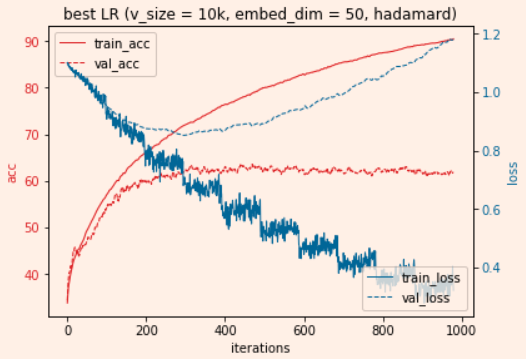

In [162]:
# model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce)

# train_dataset = NewsGroupDataset(hypo_data_indices_train, prem_data_indices_train, label_index_train, max_sentence_length)
# val_dataset = NewsGroupDataset(hypo_data_indices_val, prem_data_indices_val, label_index_val,max_sentence_length)
#
#
# # TODO:
# # finish DataLoader
#
# loader_train = DataLoader(train_dataset, batch_size=1024, collate_fn=newsgroup_collate_func,
#                                   shuffle = True, num_workers=0)
# loader_val = DataLoader(val_dataset, batch_size=1024, collate_fn=newsgroup_collate_func,
#                                   shuffle = True, num_workers=0)

# token2id, id2token = build_vocab(hypo_data_tokens_train, prem_data_tokens_train, max_vocab_size=10000)
#
# hypo_data_indices_train = token2index(hypo_data_tokens_train)
# prem_data_indices_train = token2index(prem_data_tokens_train)
#
# hypo_data_indices_val = token2index(hypo_data_tokens_val)
# prem_data_indices_val= token2index(prem_data_tokens_val)


def hyper_tuning(emb_dim,reduce,optimizer,max_vocab_size,learning_rate):
    global token2id
    token2id, id2token = build_vocab(hypo_data_tokens_train, prem_data_tokens_train,max_vocab_size)
    
    hypo_data_indices_train = token2index(hypo_data_tokens_train)
    prem_data_indices_train = token2index(prem_data_tokens_train)
    hypo_data_indices_val = token2index(hypo_data_tokens_val)
    prem_data_indices_val= token2index(prem_data_tokens_val) 
    
    batch_size = 1024
    train_dataset = NewsGroupDataset(hypo_data_indices_train, prem_data_indices_train, label_index_train, max_sentence_length)
    val_dataset = NewsGroupDataset(hypo_data_indices_val, prem_data_indices_val, label_index_val,max_sentence_length)
    train_input = DataLoader(train_dataset,batch_size = 1024, collate_fn = newsgroup_collate_func,shuffle = True,num_workers = 0)
    val_input = DataLoader(val_dataset,batch_size = 1024, collate_fn = newsgroup_collate_func,shuffle = True,num_workers = 0)
    
    num_epochs = 10 
    
    model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce)
   
    criterion = torch.nn.CrossEntropyLoss()
    if optimizer == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    train_losses = [] # record training loss after every epoch
    val_losses = [] # record validation loss after every epoch
    train_accs = [] # record training accuracy after every epoch
    val_accs = [] # record validation accuracy after every epoch

    train_losses_batch = [] # record training loss after every batch
    val_losses_batch = [] # record validation loss after every batch
    train_accs_batch = [] # record training accuracy after every batch
    val_accs_batch = [] # record validation accuracy after every batch
    
    for epoch in range(num_epochs):
        model.train()
        correct_ttl =0
        ttl=0
        correct_ttl_val=0
       
    
        for i, batch in enumerate(loader_train):
            #zero-out the gradients managed by your optimizer

            target = batch[4]

            optimizer.zero_grad()
            # Compute the predicted log-probabilities
            logits = model(batch[0], batch[1], batch[2],batch[3],reduce)
            # Compute the loss
            loss = criterion(logits, target)

            #record training loss
            train_losses_batch.append(loss.item())

            #determine predicted label by choosing the index of the element with highest probability
            max_probs,preds = torch.max(logits,dim=1)
            correct=(preds==target).sum()
            

            batch_size=target.size(0)
            accuracy = correct/batch_size
            train_accs_batch.append(accuracy)

            # Back-propagate the gradients to the parameters
            loss.backward()
            # Apply the gradient updates to the parameters
            optimizer.step()
        
        #save model
        save_models(model, os.path.join(path, 'model'), [max_vocab_size,emb_dim,reduce,learning_rate]);


        train_losses.append(np.mean(np.array(train_losses_batch)))

        #avg_train_acc = correct_ttl/ttl
        avg_train_acc = np.mean(np.array(train_accs_batch))
        train_accs.append(avg_train_acc)

    #do valid
        model.eval()
        ttll = 0
       
        with torch.no_grad():
            for i, batch in enumerate(loader_val):

                target = batch[4] 
                batch_size = target.size(0)
                logits = model(batch[0], batch[1], batch[2],batch[3],reduce)
                loss = criterion(logits, target)
                val_losses_batch.append(loss.item())

                #determine predicted label by choosing the index of the element with highest probability
                max_probs,preds = torch.max(logits,dim=1)
                correct_val=(preds==target).sum()


                accuracy_val = correct_val/batch_size
                val_accs_batch.append(accuracy_val)

            val_losses.append(np.mean(np.array(val_losses_batch)))
            val_accs.append(np.mean(np.array(val_accs_batch)))
    print('validation accuracy:',val_accs)
    
        
    fig, ax1 = plt.subplots()
    epochs = np.array(list(range(num_epochs)))
    ax1.plot(epochs, train_losses, label='Train loss',color = 'b')
    ax1.plot(epochs, val_losses, label='Valid loss', color = 'b',linestyle = '--')

    ax1.legend()
    ax2 = ax1.twinx()
    ax2.plot(epochs,train_accs,label = 'Train accuracy',color = 'r')
    ax2.plot(epochs, val_accs, label = 'Val accuracy',color = 'r',linestyle = '--')
    ax2.legend()
    plt.title('LR (v = {}, embed = {}, optimizer = {}, {},{})'.format(max_vocab_size,emb_dim,'Adam',reduce,learning_rate))
    plt.show()


In [163]:
for tune in list(itertools.product(*param)):
    print(tune)

(50, 'sum', 'Adam', 10000, 0.01)
(50, 'sum', 'Adam', 10000, 0.05)
(50, 'sum', 'Adam', 10000, 0.1)
(50, 'sum', 'Adam', 10000, 0.2)
(50, 'hadamard', 'Adam', 10000, 0.01)
(50, 'hadamard', 'Adam', 10000, 0.05)
(50, 'hadamard', 'Adam', 10000, 0.1)
(50, 'hadamard', 'Adam', 10000, 0.2)


## Tuning over learning rate

100%|██████████| 1000/1000 [00:00<00:00, 359193.63it/s]


validation accuracy: [0.5, 0.5245, 0.5373333, 0.54649997, 0.5519999, 0.5544999, 0.55642855, 0.558875, 0.5606667, 0.5621]


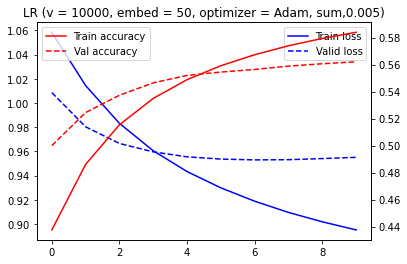

100%|██████████| 1000/1000 [00:00<00:00, 415113.22it/s]


validation accuracy: [0.552, 0.56649995, 0.5683333, 0.56825, 0.5686, 0.5685, 0.56871426, 0.567375, 0.5685556, 0.5689]


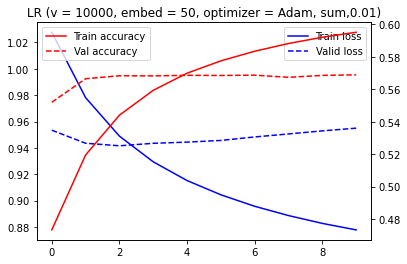

100%|██████████| 1000/1000 [00:00<00:00, 468846.86it/s]


validation accuracy: [0.56, 0.5625, 0.5653333, 0.56725, 0.5666, 0.5671667, 0.568, 0.566875, 0.5663333, 0.56639993]


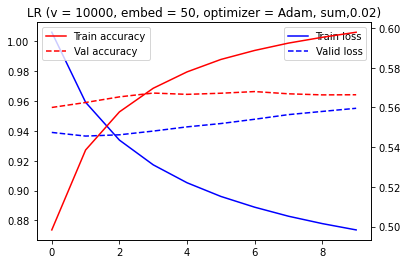

100%|██████████| 1000/1000 [00:00<00:00, 447440.15it/s]


validation accuracy: [0.576, 0.571, 0.566, 0.566, 0.5638, 0.56366664, 0.56314284, 0.563625, 0.5634444, 0.56359994]


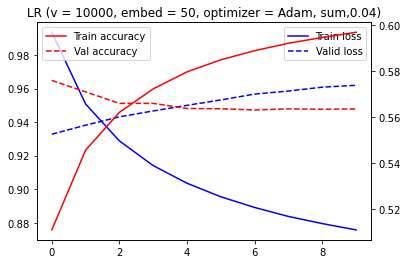

100%|██████████| 1000/1000 [00:00<00:00, 388613.36it/s]


validation accuracy: [0.487, 0.5215, 0.543, 0.55775, 0.56939995, 0.578, 0.5852857, 0.5915, 0.59577775, 0.5998]


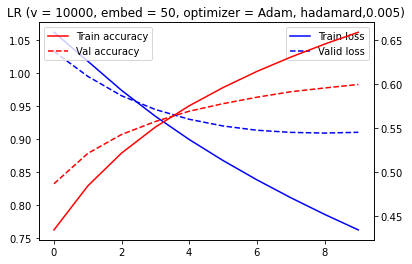

100%|██████████| 1000/1000 [00:00<00:00, 386109.18it/s]


validation accuracy: [0.532, 0.5665, 0.5876667, 0.59825003, 0.6066, 0.61216664, 0.61471426, 0.616125, 0.6171111, 0.6166]


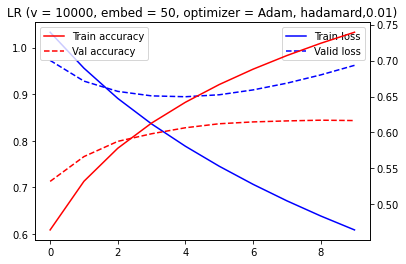

100%|██████████| 1000/1000 [00:00<00:00, 431290.90it/s]


validation accuracy: [0.585, 0.6085, 0.614, 0.6195, 0.62259996, 0.6231666, 0.6234285, 0.623875, 0.62366664, 0.6239]


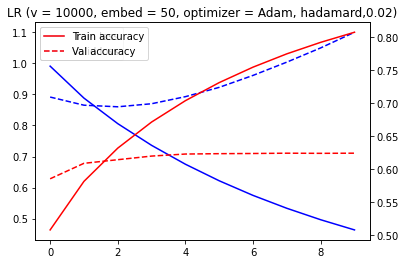

100%|██████████| 1000/1000 [00:00<00:00, 394646.59it/s]


validation accuracy: [0.608, 0.6235, 0.626, 0.627, 0.6292, 0.62799996, 0.6245714, 0.62212497, 0.6211111, 0.62079996]


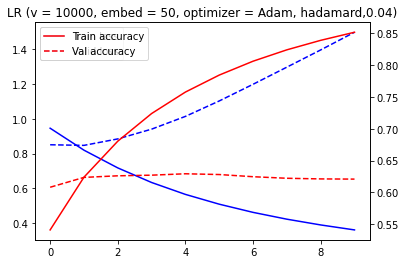

In [164]:
emb_dim1 = [50]
reduce1 = ['sum','hadamard']
optimizer1 = ['Adam']
max_vocab1 = [10000]
learning_rate1= [0.005,0.01,0.02,0.04]
param1 = [emb_dim1,reduce1,optimizer1,max_vocab1,learning_rate1]
for tune in list(itertools.product(*param1)):
    hyper_tuning(tune[0],tune[1],tune[2],tune[3],tune[4])

Above are the plots of training and validation losses and accuracies curves with 4 different learning rates as trained parameter: 0.005,0.01,0.02,0.04. 
- From the figures above, we can see if learning rate is larger, validation accuracy increases with a slower rate. When learning rate is too low (0.005), val acc is still increasing at the end of the last epoch trained, which means model underfitting; more epochs need to be trained to get an optimal validation accuracy. When the learning rate is large enough(0.04), the curve of validation accuracy has a decreasing trend after reaching an optimal while training accuracy increases, which means model overfitting. So learning rate 0.02 looks reasonable for both reduce ='sum'and'hadamard'.


## Tuning over emb_dim

100%|██████████| 1000/1000 [00:00<00:00, 377763.13it/s]


validation accuracy: [0.556, 0.5675, 0.569, 0.5685, 0.5678, 0.56733334, 0.5667143, 0.56824994, 0.5683333, 0.5681]


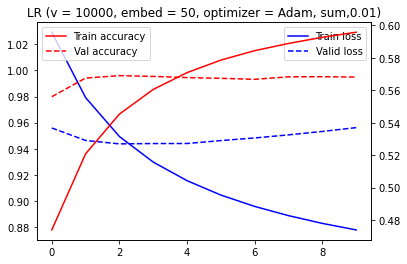

100%|██████████| 1000/1000 [00:00<00:00, 407372.18it/s]


validation accuracy: [0.548, 0.5755, 0.59, 0.60025, 0.60580003, 0.60833335, 0.6114286, 0.61387503, 0.6142223, 0.6143001]


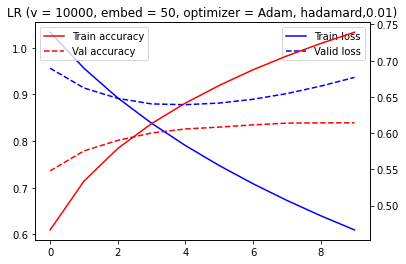

100%|██████████| 1000/1000 [00:00<00:00, 380090.98it/s]


validation accuracy: [0.556, 0.5635, 0.565, 0.564, 0.561, 0.5621667, 0.5615715, 0.56112504, 0.56088895, 0.56090003]


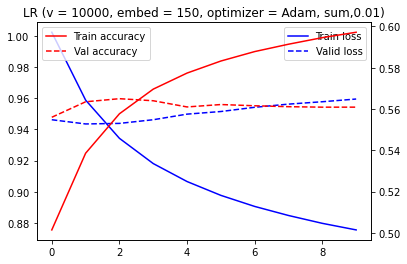

100%|██████████| 1000/1000 [00:00<00:00, 391588.46it/s]


validation accuracy: [0.574, 0.598, 0.60899997, 0.61525, 0.619, 0.621, 0.6222857, 0.62275, 0.6223333, 0.62219995]


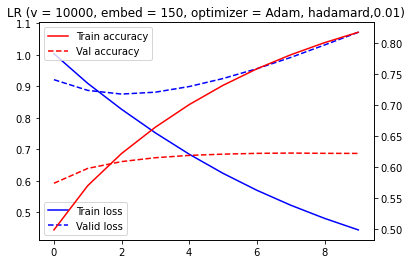

100%|██████████| 1000/1000 [00:00<00:00, 405677.92it/s]


validation accuracy: [0.569, 0.564, 0.565, 0.56325, 0.566, 0.5653333, 0.5641428, 0.56375, 0.563, 0.56210005]


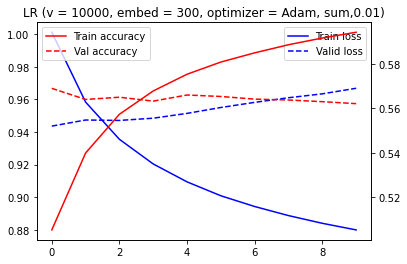

100%|██████████| 1000/1000 [00:00<00:00, 419095.12it/s]


validation accuracy: [0.59, 0.6065, 0.6186667, 0.62200004, 0.62420005, 0.6256667, 0.6274286, 0.62787503, 0.62844443, 0.6287]


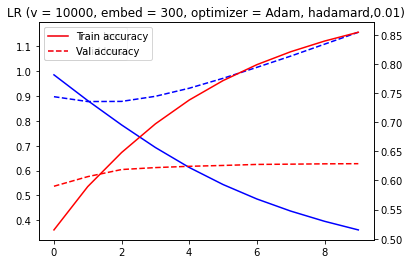

100%|██████████| 1000/1000 [00:00<00:00, 454125.60it/s]


validation accuracy: [0.56, 0.5655, 0.564, 0.56175, 0.5598, 0.56, 0.5615715, 0.5605, 0.56088895, 0.5619]


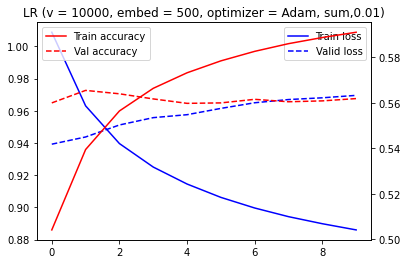

100%|██████████| 1000/1000 [00:00<00:00, 385187.25it/s]


validation accuracy: [0.617, 0.622, 0.62266666, 0.624, 0.6242, 0.625, 0.62385714, 0.62399995, 0.62422216, 0.62389994]


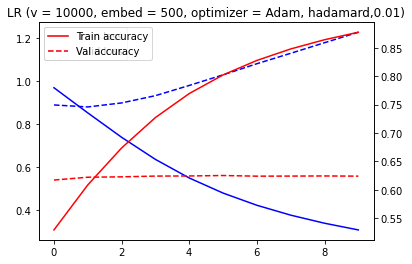

In [134]:
emb_dim2 = [50,150,300,500]
reduce2 = ['sum','hadamard']
optimizer2 = ['Adam']
max_vocab2 = [10000]
learning_rate2= [0.01]
param2 = [emb_dim2,reduce2,optimizer2,max_vocab2,learning_rate2]
for tune in list(itertools.product(*param2)):
    hyper_tuning(tune[0],tune[1],tune[2],tune[3],tune[4])

Above are the plots of training and validation losses and accuracies curves with 4 different emb_dim as trained parameter: 50,150,300,500. 
- When reduce = 'sum', emb_size=50, the model performs well. When emb_size is 150 and larger, validation accuracy increases before epoch = 1 and then slightly decreases. As the training accuracy increases after epoch 1, it indicates that the model is overfitting.
- With the increase of emb_size, when reduce = 'hadamard', the validation performances look similar. If emb_size is larger, the validation accuracy increases slower. When emb_size = 300, validation accuracy has the highest value.

**Written 2:** (4 pts)   
Take your best model based on validation performace and report its validation accuracy:

100%|██████████| 1000/1000 [00:00<00:00, 339372.44it/s]


validation accuracy: [0.587, 0.6075, 0.61866665, 0.6215, 0.6256, 0.62583333, 0.6252857, 0.62425, 0.62299997, 0.62149996]


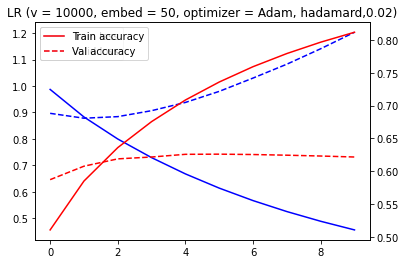

In [178]:
#param = [emb_dim2,reduce2,optimizer2,max_vocab2,learning_rate2]
hyper_tuning(50,'hadamard','Adam',10000,0.02)

The best model is the one with vocabulary size = 10000, embedded_size = 50,optimizer = Adam, reduce = 'hadamard', learning rate = 0.02.  In the 7th epoch, validation accuracy reaches the best: 0.6315714.

LogisticsModelPytorch(
  (embedding): Embedding(10002, 50, padding_idx=1)
  (linear): Linear(in_features=50, out_features=3, bias=True)
)

**Written 3:** (4 pts)

Highlight 3 correct and 3 incorrect predictions in this validation set. Describe why the model might have gotten the 3 incorrect predictions wrong.

In [146]:
# load trained model 
if os.path.exists(get_full_filepath(os.path.join(path, 'model'), "[10000, 50, 'hadamard', 0.02]")):
    model = torch.load(get_full_filepath(os.path.join(path, 'model'), "[10000, 50, 'hadamard', 0.02]"))
model

LogisticsModelPytorch(
  (embedding): Embedding(10002, 50, padding_idx=1)
  (linear): Linear(in_features=50, out_features=3, bias=True)
)

In [152]:
probs = None
hypo = None
prem = None
labels = None

preds_cache =[]
probs_cache =[]
model.eval()
with torch.no_grad():
    for i, batch in enumerate(loader_val):
        batch_size = batch[0].size(0)
        labels = batch[4]
        logits = model(batch[0],batch[1],batch[2],batch[3],reduce)
        probs_cache.append(logits)
        _, predicted = torch.max(logits, 1)
        preds_cache.append(predicted)
        correct = (predicted == labels).sum().item()
        incorrect=(predicted != labels).sum().item()
        if probs is None:
            probs = logits
            hypo = batch[0]
            prem = batch[2]
            labels = labels
        else:
            probs = torch.cat((probs,logits), 0)
            hypo = torch.cat((hypo,batch[0]), 0)
            prem = torch.cat((prem,batch[2]), 0)
            labels = torch.cat((labels, labels), 0)

        


599
401
tensor([[ 0.0906, -2.3130,  2.3730],
        [-0.4431,  0.3253, -0.6518],
        [ 1.4617, -2.1882,  1.2930],
        ...,
        [ 1.6122, -1.2106, -0.5504],
        [ 0.9115, -3.2599,  1.1196],
        [ 1.6923, -1.3633, -1.4741]])


In [175]:
def translate_ids(tensor):
    return " ".join([id2token[idx.item()] for idx in tensor])

label_mask = (torch.argmax(probs,dim=1)==labels)
masked_cor = torch.where(label_mask, torch.max(probs,dim=1)[0], torch.zeros_like(torch.max(probs,dim=1)[0]))
#top corrects
top = torch.topk(masked_cor,3)[1]
masked_in = torch.where(label_mask!=True, torch.max(probs,dim=1)[0], torch.zeros_like(torch.max(probs,dim=1)[0]))
#top incorrects
in_top = torch.topk(masked_in,3)[1]

selected_hypo = [hypo[idx.item()] for idx in top]
selected_prem = [prem[idx.item()] for idx in top]
trans_hypo = [translate_ids(t) for t in selected_hypo]
trans_prem = [translate_ids(t) for t in selected_prem]

in_selected_hypo = [hypo[idx.item()] for idx in in_top]
in_selected_prem = [prem[idx.item()] for idx in in_top]
in_trans_hypo = [translate_ids(t) for t in in_selected_hypo]
in_trans_prem = [translate_ids(t) for t in in_selected_prem]

#top incorrect label
in_pred = torch.argmax(probs,dim = 1)[in_top]
#top actual label
actual = labels[in_top]


In [177]:
print('\n','correct hypothesises:')
for i in trans_hypo: print(i)
print('\n','correct premises:')
for i in trans_prem: print(i)
print('\n','incorrect hypothesises:')
for i in incorrect_trans_hypo:print(i)
print('\n','incorrect premises:')
for i in incorrect_trans_prem:print(i)
print('\n','label of incorrect:',in_pred)
print('\n','actual label:', actual)


 correct hypothesises:
a lady sitting on a bench that is against a building and under a poster of a man in a
several young african americans giving an outdoor dance performance <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
an elderly man is looking through his glasses while working with hot metal <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

 correct premises:
nobody is sitting <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
a woman drinks poison <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
girl sleeps <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

 incorrect hypothesises:
a woman lies on a bed with a red orange and blue striped comforter <UNK> up next to her <UNK>
a white race dog wearing the number eight runs on the track <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
a baseball player sliding toward 

1. This is actually a contradiction but wrongly predicted as an entailment. Maybe it is due to the unknown keyward among the words in hypothesis sentence.
2. This is a neutral but wrongly predicted as an entailment. Maybe it is because the premise and hypothesis have the same subject:'dog' and verbs are somehow related. The model might consider these two subjects are the same and doing related things so it classified this as entailment.
3. This is a neutral but wrongly predicted as an entailment. Two sentences both contains'a basketball player','sliding','toward','base'. It is highly possible that the model might think if the premise is true, the hypothesis must be true.